# SSD300 Inference Tutorial

This is a brief tutorial that shows how to use a trained SSD300 for inference on the Pascal VOC datasets. If you'd like more detailed explanations, please refer to [`ssd300_training.ipynb`](https://github.com/pierluigiferrari/ssd_keras/blob/master/ssd300_training.ipynb)

In [1]:
from keras import backend as K
from keras.models import load_model
from keras.preprocessing import image
from keras.optimizers import Adam
from scipy.stats import entropy
from imageio import imread
import numpy as np
from matplotlib import pyplot as plt
import os
import glob

from models.keras_ssd300 import ssd_300
from keras_loss_function.keras_ssd_loss import SSDLoss
from keras_layers.keras_layer_AnchorBoxes import AnchorBoxes
from keras_layers.keras_layer_DecodeDetections import DecodeDetections
from keras_layers.keras_layer_DecodeDetectionsFast import DecodeDetectionsFast
from keras_layers.keras_layer_L2Normalization import L2Normalization
from keras.layers import TimeDistributed
from keras.models import Model
from ssd_encoder_decoder.ssd_output_decoder_dropout import decode_detections

from data_generator.object_detection_2d_data_generator import DataGenerator
from data_generator.object_detection_2d_photometric_ops import ConvertTo3Channels
from data_generator.object_detection_2d_geometric_ops import Resize
from data_generator.object_detection_2d_misc_utils import apply_inverse_transforms

from bounding_box_utils.bounding_box_utils import iou

from tqdm import tqdm_notebook as tqdm

%matplotlib inline

Using TensorFlow backend.


In [2]:
# Set the image size.
img_height = 300
img_width = 300

## 1. Load a trained SSD

Either load a trained model or build a model and load trained weights into it. Since the HDF5 files I'm providing contain only the weights for the various SSD versions, not the complete models, you'll have to go with the latter option when using this implementation for the first time. You can then of course save the model and next time load the full model directly, without having to build it.

You can find the download links to all the trained model weights in the README.

### 1.1. Build the model and load trained weights into it

In [3]:
# Define parameters
img_height = 300 # Height of the model input images
img_width = 300 # Width of the model input images
img_channels = 3 # Number of color channels of the model input images
mean_color = [123, 117, 104] # The per-channel mean of the images in the dataset. Do not change this value if you're using any of the pre-trained weights.
swap_channels = [2, 1, 0] # The color channel order in the original SSD is BGR, so we'll have the model reverse the color channel order of the input images.
n_classes = 20 # Number of positive classes, e.g. 20 for Pascal VOC, 80 for MS COCO
scales_pascal = [0.1, 0.2, 0.37, 0.54, 0.71, 0.88, 1.05] # The anchor box scaling factors used in the original SSD300 for the Pascal VOC datasets
scales_coco = [0.07, 0.15, 0.33, 0.51, 0.69, 0.87, 1.05] # The anchor box scaling factors used in the original SSD300 for the MS COCO datasets
scales = scales_pascal
aspect_ratios = [[1.0, 2.0, 0.5],
                 [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                 [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                 [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                 [1.0, 2.0, 0.5],
                 [1.0, 2.0, 0.5]] # The anchor box aspect ratios used in the original SSD300; the order matters
two_boxes_for_ar1 = True
steps = [8, 16, 32, 64, 100, 300] # The space between two adjacent anchor box center points for each predictor layer.
offsets = [0.5, 0.5, 0.5, 0.5, 0.5, 0.5] # The offsets of the first anchor box center points from the top and left borders of the image as a fraction of the step size for each predictor layer.
clip_boxes = False # Whether or not to clip the anchor boxes to lie entirely within the image boundaries
variances = [0.1, 0.1, 0.2, 0.2] # The variances by which the encoded target coordinates are divided as in the original implementation
normalize_coords = True
N = 40 # Number of passes through the network

In [4]:
# 1: Build the Keras model

K.clear_session() # Clear previous models from memory.

model = ssd_300(image_size=(img_height, img_width, img_channels),
                n_classes=n_classes,
                mode='training',
                l2_regularization=0.0005,
                scales=scales,
                aspect_ratios_per_layer=aspect_ratios,
                two_boxes_for_ar1=two_boxes_for_ar1,
                steps=steps,
                offsets=offsets,
                clip_boxes=clip_boxes,
                variances=variances,
                normalize_coords=normalize_coords,
                subtract_mean=mean_color,
                swap_channels=swap_channels)


# 2: Load the trained weights into the model.

# TODO: Set the path of the trained weights.
weights_path = 'good_dropout_model/ssd300_dropout_pascal_07+12_epoch-114_loss-4.3685_val_loss-4.5034.h5'

model.load_weights(weights_path, by_name=True)

# 3: Compile the model so that Keras won't complain the next time you load it.

adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

ssd_loss = SSDLoss(neg_pos_ratio=3, alpha=1.0)

model.compile(optimizer=adam, loss=ssd_loss.compute_loss)

W1008 11:00:17.903037 140079031076608 deprecation_wrapper.py:119] From /home/vision/msmith/localDrive/msmith/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:95: The name tf.reset_default_graph is deprecated. Please use tf.compat.v1.reset_default_graph instead.

W1008 11:00:17.904976 140079031076608 deprecation_wrapper.py:119] From /home/vision/msmith/localDrive/msmith/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:98: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W1008 11:00:17.936705 140079031076608 deprecation_wrapper.py:119] From /home/vision/msmith/localDrive/msmith/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:102: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1008 11:00:17.938521 140079031076608 deprecation_wrapper.py:119] From /home/vision/msmith/localDrive/msmith/anaconda3/lib/python

In [5]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 300, 300, 3)  0                                            
__________________________________________________________________________________________________
identity_layer (Lambda)         (None, 300, 300, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
input_mean_normalization (Lambd (None, 300, 300, 3)  0           identity_layer[0][0]             
__________________________________________________________________________________________________
input_channel_swap (Lambda)     (None, 300, 300, 3)  0           input_mean_normalization[0][0]   
__________________________________________________________________________________________________
conv1_1 (C

Or

### 1.2. Load a trained model

In [3]:
# TODO: Set the path to the `.h5` file of the model to be loaded.
model_path = 'good_dropout_model/ssd300_dropout_pascal_07+12_epoch-114_loss-4.3685_val_loss-4.5034.h5'

# We need to create an SSDLoss object in order to pass that to the model loader.
ssd_loss = SSDLoss(neg_pos_ratio=3, n_neg_min=0, alpha=1.0)

K.clear_session() # Clear previous models from memory.

model = load_model(model_path, custom_objects={'AnchorBoxes': AnchorBoxes,
                                               'L2Normalization': L2Normalization,
                                               'DecodeDetections': DecodeDetections,
                                               'compute_loss': ssd_loss.compute_loss})

W0925 11:32:56.313899 140007919253248 deprecation_wrapper.py:119] From /home/vision/msmith/localDrive/msmith/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:95: The name tf.reset_default_graph is deprecated. Please use tf.compat.v1.reset_default_graph instead.

W0925 11:32:56.317215 140007919253248 deprecation_wrapper.py:119] From /home/vision/msmith/localDrive/msmith/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:98: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0925 11:32:56.354900 140007919253248 deprecation_wrapper.py:119] From /home/vision/msmith/localDrive/msmith/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:102: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0925 11:32:56.359556 140007919253248 deprecation_wrapper.py:119] From /home/vision/msmith/localDrive/msmith/anaconda3/lib/python

## 2. Load some images

Load some images for which you'd like the model to make predictions.

In [59]:
orig_images = [] # Store the images here.
input_images = [] # Store resized versions of the images here.

# We'll only load one image in this example.
img_root = '/usr/local/data/msmith/bike_photos'
files = glob.glob(os.path.join(img_root, '*.jpg'))
files.sort()

counter = 0

for f in tqdm(files):
    orig_images.append(imread(f))
    img = image.load_img(f, target_size=(img_height, img_width))
    img = image.img_to_array(img) 
    input_images.append(img)
    counter += 1
    if counter >= 1000:
        break
        
if len(files) < 1000:
    max_img = len(files)
else:
    max_img = 1000

input_images = np.array(input_images)

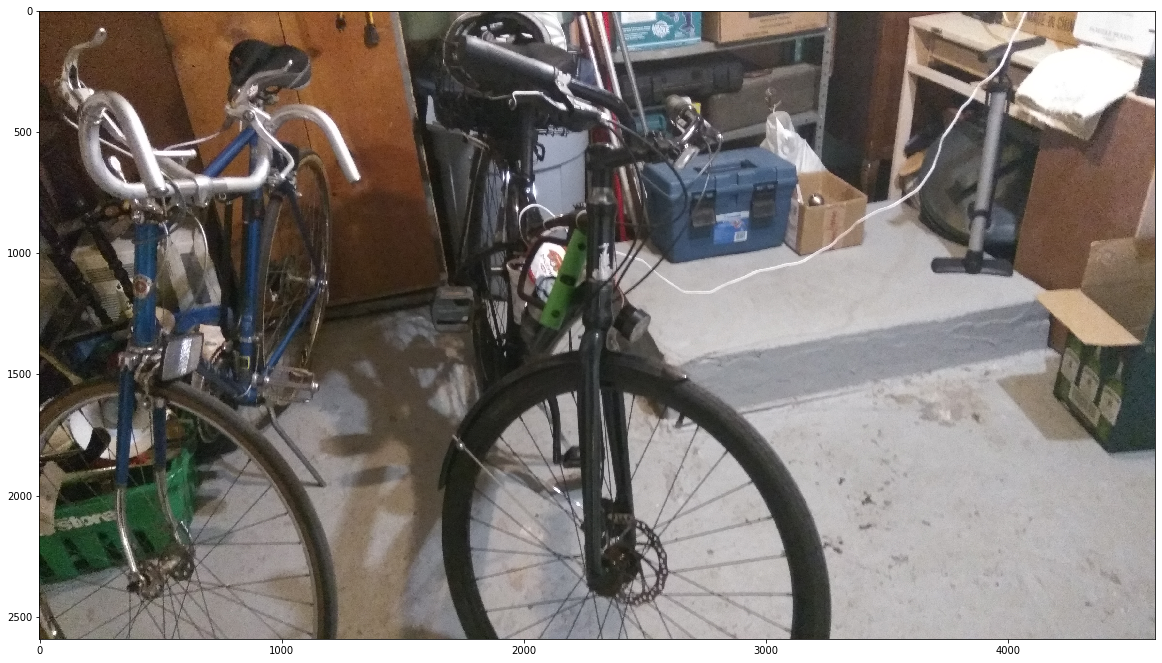

In [60]:
plt.figure(figsize=(20,12))
plt.imshow(orig_images[2])

## 3. Make predictions

In [61]:
# Make N predictions
y_pred = []
for i in tqdm(range(N)):
    y_pred.append(model.predict(input_images))

`y_pred` contains a fixed number of predictions per batch item (200 if you use the original model configuration), many of which are low-confidence predictions or dummy entries. We therefore need to apply a confidence threshold to filter out the bad predictions. Set this confidence threshold value how you see fit.

In [62]:
# NMS/Filter predictions into higher probability detections for each run
y_pred_decoded = []
for i in tqdm(range(N)):
    y_pred_decoded.append(decode_detections(y_pred[i],
                                       confidence_thresh=0.1,
                                       iou_threshold=0.1,
                                       top_k=200,
                                       normalize_coords=normalize_coords,
                                       img_height=img_height,
                                       img_width=img_width))

In [63]:
# Partition detections into observations
y_pred_decoded = np.array(y_pred_decoded)
observations_per_img = []
for i in range(max_img): # Iterate over all images
    concated = np.concatenate(y_pred_decoded[:,i])
    observations = []
    while concated.shape[0] > 0: # Continue until no more observations
        box = concated[0, :] # Get bounding box for first image in array; we continuously remove entries from this array
        ious = iou(concated[:, -4:], box[-4:], coords='corners', border_pixels='half', mode='element-wise') # Find matching boxes in image
        keep_idx = ious >= 0.65
        observations.append(concated[keep_idx, :]) # Lump together a bunch of detections into an observation
        concated = concated[np.invert(keep_idx),:] # Remove the boxes we are keeping from the array
    observations_per_img.append(np.array(observations))

# Indexing : [image #][observation #]

## 4. Visualize the predictions

We just resized the input image above and made predictions on the distorted image. We'd like to visualize the predictions on the image in its original size though, so below we'll transform the coordinates of the predicted boxes accordingly.

In [64]:
# Get label probabilities
observations_decoded_per_img = []
for i in range(max_img):
    observations_decoded = []
    for obs in observations_per_img[i]:
        # in observation: index 0-class id of max, 1-confidence of said class, 2-23 inclusive: softmax values, 24-27: box coordinates
        means = np.mean(obs[:,2:], axis=0) # Get mean values of softmax and boxes per paper

        ent = entropy(means[:-4]) # Get uncertainty estimate using entropy of mean
        # Note that we are throwing away potentially useful info here...
        new_class = np.argmax(means[1:-4]) + 1 # Get max class (ignoring background)
        new_obs = np.empty((28))
        
        new_obs[0:3] = [new_class, means[new_class], ent]
        new_obs[3:] = means
        # New format: class id, associated normalized class softmax confidence, entropy value (normalized by function), 21 softmax values, 4 bounding box values
        observations_decoded.append(new_obs)
    observations_decoded = np.array(observations_decoded)
    observations_decoded = observations_decoded[observations_decoded[:,1].argsort()]
    observations_decoded_per_img.append(observations_decoded)
    # Index format: [img #][observation #]

In [65]:
# Max entropy of 21 values slightly greater than 3
# Min is 0 obviously

In [65]:
observations_decoded_per_img[0]

array([[  7.        ,   0.10355132,   0.5592055 ,   0.85966539,
          0.00010245,   0.0003591 ,   0.00004368,   0.0003709 ,
          0.00923602,   0.00042231,   0.10355132,   0.00019863,
          0.00385082,   0.0002162 ,   0.00058758,   0.00012946,
          0.00010757,   0.00553632,   0.00904244,   0.00042586,
          0.000272  ,   0.0001688 ,   0.00038547,   0.00532768,
        229.37322557,  -5.64011782, 293.18076074,  90.58567286],
       [ 15.        ,   0.14064121,   0.76358841,   0.79318504,
          0.00009842,   0.02626492,   0.00010508,   0.00119443,
          0.0056844 ,   0.00028975,   0.00497702,   0.00002528,
          0.00870499,   0.0001832 ,   0.00156928,   0.00017559,
          0.00201897,   0.01219351,   0.14064121,   0.00117045,
          0.00009167,   0.00007368,   0.00092301,   0.0004301 ,
        227.99915724, -11.96615407, 295.43321886, 218.11850194],
       [ 15.        ,   0.31942447,   0.8709879 ,   0.62522804,
          0.00002315,   0.03867979,   

In [66]:
np.set_printoptions(suppress=True)

print('Class | Softmax value | Entropy | BBox values')
print('Image 0')
print(observations_decoded_per_img[0][:, np.r_[0:3,24:28]])
print('Image 1')
print(observations_decoded_per_img[1][:, np.r_[0:3,24:28]])
print('Image 2')
print(observations_decoded_per_img[2][:, np.r_[0:3,24:28]])


Class | Softmax value | Entropy | BBox values
Image 0
[[  7.           0.10355132   0.5592055  229.37322557  -5.64011782
  293.18076074  90.58567286]
 [ 15.           0.14064121   0.76358841 227.99915724 -11.96615407
  295.43321886 218.11850194]
 [ 15.           0.31942447   0.8709879  169.40463692  17.29857288
  230.0767377  203.12289253]
 [  2.           0.94185081   0.27067382  66.24117114   8.30219261
  223.54825884 287.63704598]]
Image 1
[[  9.           0.1054372    0.37959501 189.52726722   3.31694931
  233.53359103  63.73739094]
 [  9.           0.10558062   0.42943599  92.11892411  -1.75184458
  142.39726737  59.9859383 ]
 [  2.           0.13339335   0.74968149 191.71857253   7.10685231
  292.448477   289.25499111]
 [ 20.           0.14306119   0.49448955 207.75445104  25.48640817
  256.18842244  91.60194397]
 [  2.           0.85682336   0.5211972    1.94477119  14.47418779
  184.07578245 295.82406878]]
Image 2
[[ 15.           0.10215419   0.74073978   1.63903534   4.016759

In [79]:
# Print my bike softmaxes
softmax1 = observations_decoded_per_img[0][3, 3:24]
softmax2 = observations_decoded_per_img[1][4, 3:24]
softmax3 = observations_decoded_per_img[2][3, 3:24]

combined = (softmax1 * softmax2 * softmax3) / np.sum(softmax1 * softmax2 * softmax3)

In [80]:
print(combined)

[0.00002702 0.         0.99995658 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.00001638 0.00000002 0.         0.
 0.         0.         0.        ]


In [68]:
# Disable showing plot
plt.ioff()
#plt.ion()

# Set the colors for the bounding boxes
colors = plt.cm.hsv(np.linspace(0, 1, 21)).tolist()
classes = ['background',
           'aeroplane', 'bicycle', 'bird', 'boat',
           'bottle', 'bus', 'car', 'cat',
           'chair', 'cow', 'diningtable', 'dog',
           'horse', 'motorbike', 'person', 'pottedplant',
           'sheep', 'sofa', 'train', 'tvmonitor']

save_dir = '/usr/local/data/msmith/bike_output/'

# Display the image and draw the predicted boxes onto it.
for i in tqdm(range(max_img)):
    observations_decoded = observations_decoded_per_img[i]

    plt.figure(figsize=(20,12))
    plt.imshow(orig_images[i])
    plt.axis('off')

    current_axis = plt.gca()

    for observation in observations_decoded:
        # Transform the predicted bounding boxes for the 300x300 image to the original image dimensions.
        xmin = observation[-4] * orig_images[i].shape[1] / img_width
        ymin = observation[-3] * orig_images[i].shape[0] / img_height
        xmax = observation[-2] * orig_images[i].shape[1] / img_width
        ymax = observation[-1] * orig_images[i].shape[0] / img_height
        color = colors[int(observation[0])]
        label = '{}: {:.2f} ± {:.2f}'.format(classes[int(observation[0])], observation[1], observation[2])
        current_axis.add_patch(plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, color=color, fill=False, linewidth=2))  
        current_axis.text(xmin, ymin, label, size='medium', color='white', bbox={'facecolor':color, 'alpha':1.0})
        
    filename = os.path.splitext(os.path.split(files[i])[1])[0]
    
    plt.savefig(os.path.join(save_dir, filename + '.jpg'), bbox_inches='tight', pad_inches=0)
    
    plt.close()

In [76]:
for i in tqdm(range(5)): # First 5 images
    observations_decoded = observations_decoded_per_img[i]
    print('Image {}'.format(i))
    for observation in observations_decoded:
        xmin = observation[-4] * orig_images[i].shape[1] / img_width
        ymin = observation[-3] * orig_images[i].shape[0] / img_height
        xmax = observation[-2] * orig_images[i].shape[1] / img_width
        ymax = observation[-1] * orig_images[i].shape[0] / img_height
        print('Observation: {}:{:.2f} | {:.2f}'.format(classes[int(observation[0])], observation[1], observation[2]))
        print('Xmin: {:.2f}, Ymin: {:.2f}, Xmax: {:.2f}, Ymax:{:.2f}'.format(xmin, ymin, xmax, ymax))
    print('\n', end='')

Image 0
Observation: chair:0.11 | 0.44
Xmin: 944.70, Ymin: 122.25, Xmax: 1013.38, Ymax:202.04
Observation: person:0.12 | 0.45
Xmin: 99.70, Ymin: 208.21, Xmax: 159.34, Ymax:283.68
Observation: chair:0.14 | 0.48
Xmin: 907.63, Ymin: 19.75, Xmax: 982.64, Ymax:97.51
Observation: bus:0.23 | 0.84
Xmin: 170.73, Ymin: 160.16, Xmax: 322.70, Ymax:223.41
Observation: person:0.31 | 1.05
Xmin: 1112.38, Ymin: 186.02, Xmax: 1208.65, Ymax:310.47
Observation: bicycle:0.36 | 1.01
Xmin: 772.53, Ymin: 243.66, Xmax: 884.00, Ymax:373.92
Observation: car:0.38 | 0.83
Xmin: 671.19, Ymin: 194.57, Xmax: 752.96, Ymax:233.65
Observation: car:0.61 | 0.95
Xmin: 294.86, Ymin: 164.01, Xmax: 462.43, Ymax:288.17
Observation: person:0.64 | 0.70
Xmin: 766.98, Ymin: 175.31, Xmax: 874.94, Ymax:358.98

Image 1
Observation: bus:0.10 | 0.61
Xmin: 181.53, Ymin: 157.80, Xmax: 316.35, Ymax:266.48
Observation: chair:0.11 | 0.42
Xmin: 983.46, Ymin: 141.49, Xmax: 1044.42, Ymax:207.44
Observation: bicycle:0.16 | 0.85
Xmin: 780.23, Ymi

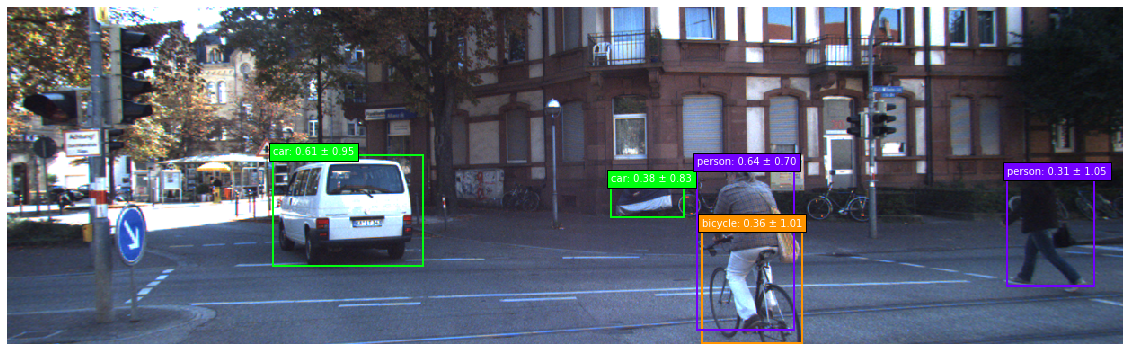

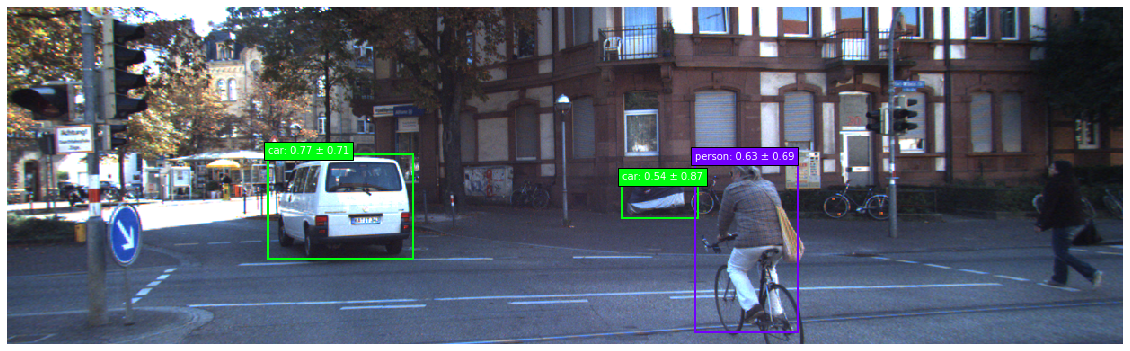

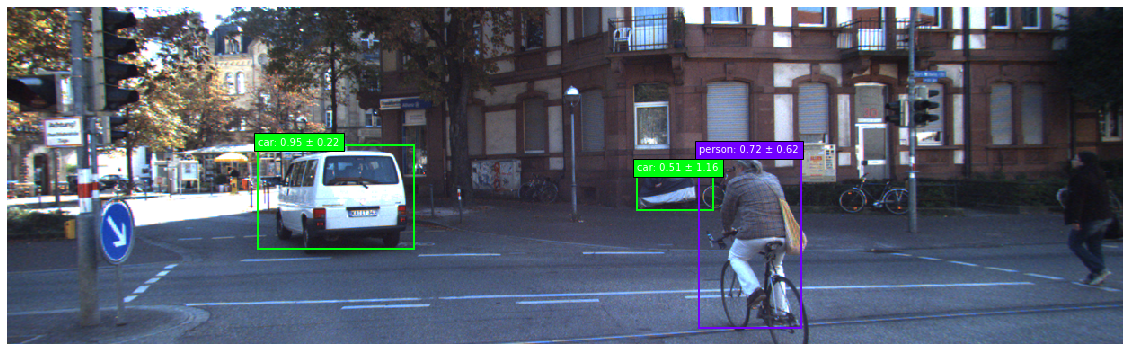

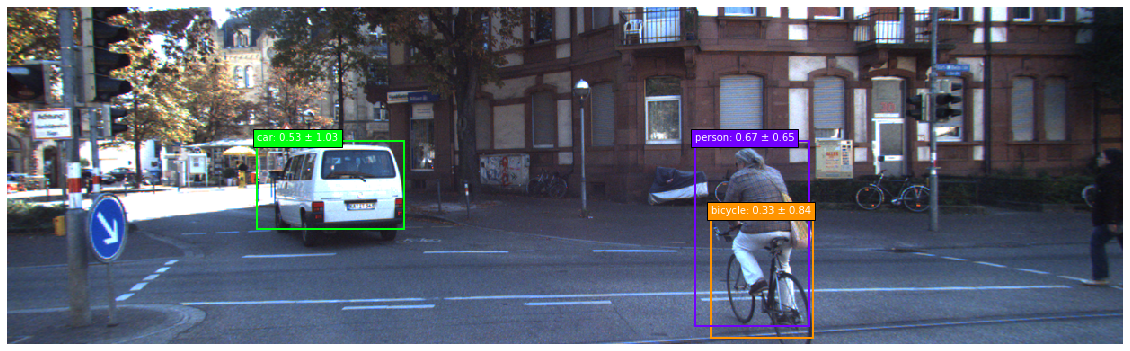

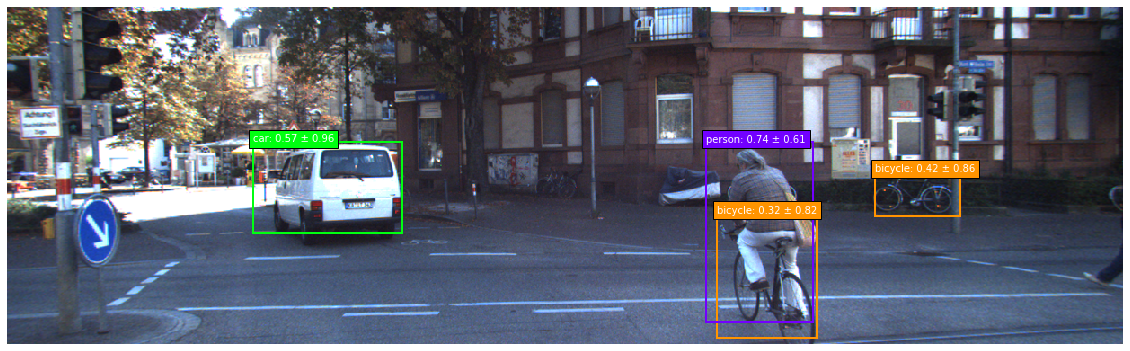

In [71]:
plt.ion()
# Display the image and draw the predicted boxes onto it.
for i in tqdm(range(5)): # First 5 images
    observations_decoded = observations_decoded_per_img[i]

    plt.figure(figsize=(20,12))
    plt.imshow(orig_images[i])
    plt.axis('off')

    current_axis = plt.gca()

    for observation in observations_decoded:
        # Transform the predicted bounding boxes for the 300x300 image to the original image dimensions.
        xmin = observation[-4] * orig_images[i].shape[1] / img_width
        ymin = observation[-3] * orig_images[i].shape[0] / img_height
        xmax = observation[-2] * orig_images[i].shape[1] / img_width
        ymax = observation[-1] * orig_images[i].shape[0] / img_height
        color = colors[int(observation[0])]
        label = '{}: {:.2f} ± {:.2f}'.format(classes[int(observation[0])], observation[1], observation[2])
        current_axis.add_patch(plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, color=color, fill=False, linewidth=2))  
        current_axis.text(xmin, ymin, label, size='medium', color='white', bbox={'facecolor':color, 'alpha':1.0})

In [ ]:
# Make movie out of images
 import os
import glob
from natsort import natsorted
from moviepy.editor import *

base_dir = os.path.realpath("./images")
print(base_dir)

gif_name = 'pic'
fps = 24

file_list = glob.glob('*.png')  # Get all the pngs in the current directory
file_list_sorted = natsorted(file_list,reverse=False)  # Sort the images

clips = [ImageClip(m).set_duration(2)
         for m in file_list_sorted]

concat_clip = concatenate_videoclips(clips, method="compose")
concat_clip.write_videofile("test.mp4", fps=fps)

## 5. Make predictions on Pascal VOC 2007 Test

Let's use a `DataGenerator` to make predictions on the Pascal VOC 2007 test dataset and visualize the predicted boxes alongside the ground truth boxes for comparison. Everything here is preset already, but if you'd like to learn more about the data generator and its capabilities, take a look at the detailed tutorial in [this](https://github.com/pierluigiferrari/data_generator_object_detection_2d) repository.

In [10]:
# Create a `BatchGenerator` instance and parse the Pascal VOC labels.

dataset = DataGenerator()

# TODO: Set the paths to the datasets here.

VOC_2007_images_dir         = '../../datasets/VOCdevkit/VOC2007/JPEGImages/'
VOC_2007_annotations_dir    = '../../datasets/VOCdevkit/VOC2007/Annotations/'
VOC_2007_test_image_set_filename = '../../datasets/VOCdevkit/VOC2007/ImageSets/Main/test.txt'

# The XML parser needs to now what object class names to look for and in which order to map them to integers.
classes = ['background',
           'aeroplane', 'bicycle', 'bird', 'boat',
           'bottle', 'bus', 'car', 'cat',
           'chair', 'cow', 'diningtable', 'dog',
           'horse', 'motorbike', 'person', 'pottedplant',
           'sheep', 'sofa', 'train', 'tvmonitor']

dataset.parse_xml(images_dirs=[VOC_2007_images_dir],
                  image_set_filenames=[VOC_2007_test_image_set_filename],
                  annotations_dirs=[VOC_2007_annotations_dir],
                  classes=classes,
                  include_classes='all',
                  exclude_truncated=False,
                  exclude_difficult=True,
                  ret=False)

convert_to_3_channels = ConvertTo3Channels()
resize = Resize(height=img_height, width=img_width)

generator = dataset.generate(batch_size=1,
                             shuffle=True,
                             transformations=[convert_to_3_channels,
                                              resize],
                             returns={'processed_images',
                                      'filenames',
                                      'inverse_transform',
                                      'original_images',
                                      'original_labels'},
                             keep_images_without_gt=False)

test.txt: 100%|██████████| 4952/4952 [00:14<00:00, 333.96it/s]


In [13]:
# Generate a batch and make predictions.

batch_images, batch_filenames, batch_inverse_transforms, batch_original_images, batch_original_labels = next(generator)

i = 0 # Which batch item to look at

print("Image:", batch_filenames[i])
print()
print("Ground truth boxes:\n")
print(np.array(batch_original_labels[i]))

Image: ../../datasets/VOCdevkit/VOC2007/JPEGImages/004927.jpg

Ground truth boxes:

[[  7  58  26 433 303]
 [ 15 409  52 439 149]
 [ 15 369  60 394 114]
 [ 15  31  65  45 111]
 [ 15  48  67  65 110]
 [ 15  67  65  81 107]]


In [14]:
# Predict.

y_pred = model.predict(batch_images)

In [16]:
confidence_threshold = 0.5

# Perform confidence thresholding.
y_pred_thresh = [y_pred[k][y_pred[k,:,1] > confidence_threshold] for k in range(y_pred.shape[0])]

# Convert the predictions for the original image.
y_pred_thresh_inv = apply_inverse_transforms(y_pred_thresh, batch_inverse_transforms)

np.set_printoptions(precision=2, suppress=True, linewidth=90)
print("Predicted boxes:\n")
print('   class   conf xmin   ymin   xmax   ymax')
print(y_pred_thresh_inv[i])

Predicted boxes:

   class   conf xmin   ymin   xmax   ymax
[[  7.     1.    59.19  20.12 429.33 307.77]
 [ 15.     0.89 361.66  55.22 394.27 122.28]
 [ 15.     0.7   89.83  65.21 108.34 116.95]
 [ 15.     0.57 345.61  57.24 368.72 108.1 ]
 [ 15.     0.55 430.29  61.72 462.75 140.24]
 [ 15.     0.53 406.14  56.13 436.42 145.34]
 [ 15.     0.52  40.03  67.8   55.35 109.8 ]]


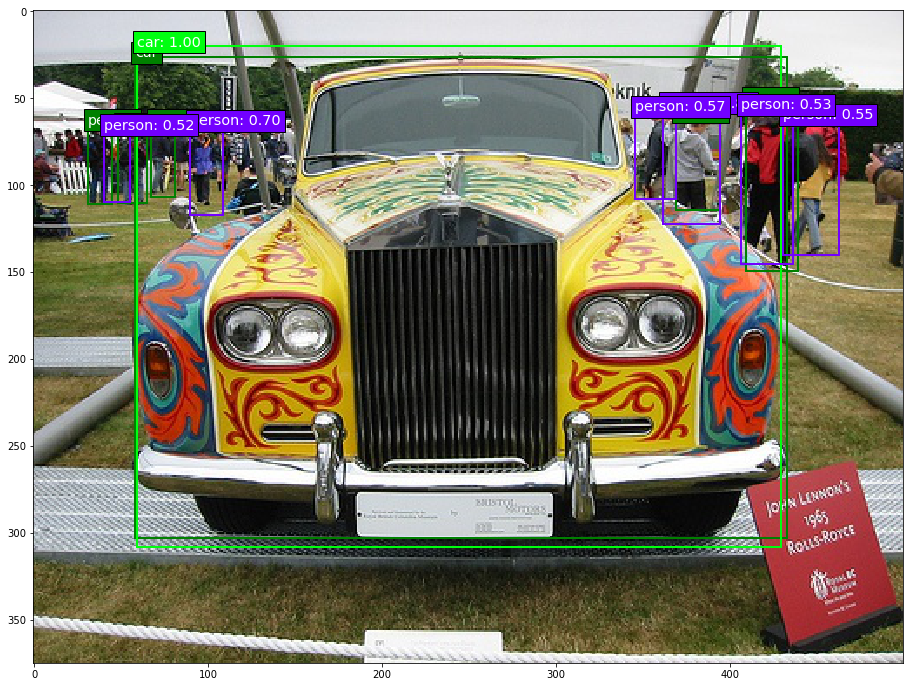

In [18]:
# Display the image and draw the predicted boxes onto it.

# Set the colors for the bounding boxes
colors = plt.cm.hsv(np.linspace(0, 1, 21)).tolist()

plt.figure(figsize=(20,12))
plt.imshow(batch_original_images[i])

current_axis = plt.gca()

for box in batch_original_labels[i]:
    xmin = box[1]
    ymin = box[2]
    xmax = box[3]
    ymax = box[4]
    label = '{}'.format(classes[int(box[0])])
    current_axis.add_patch(plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, color='green', fill=False, linewidth=2))  
    current_axis.text(xmin, ymin, label, size='x-large', color='white', bbox={'facecolor':'green', 'alpha':1.0})

for box in y_pred_thresh_inv[i]:
    xmin = box[2]
    ymin = box[3]
    xmax = box[4]
    ymax = box[5]
    color = colors[int(box[0])]
    label = '{}: {:.2f}'.format(classes[int(box[0])], box[1])
    current_axis.add_patch(plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, color=color, fill=False, linewidth=2))  
    current_axis.text(xmin, ymin, label, size='x-large', color='white', bbox={'facecolor':color, 'alpha':1.0})